### "AuthorToday" short story contest research
the goal of this research is to find out if there is any dependencies between frequency characteristics of fictional story and the viewers respond to it, measured in grades given by contest counsil and likes and views from the audience.

#### Import nessesary libraries

In [9]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pymorphy2 import MorphAnalyzer
%matplotlib inline

#### Load and examine a dataset

In [10]:
dataset = pd.read_json('final_results.json')

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            295 non-null    int64 
 1   title            295 non-null    object
 2   href             295 non-null    object
 3   access           295 non-null    object
 4   text_url         295 non-null    object
 5   likes            295 non-null    int64 
 6   views            295 non-null    int64 
 7   comments_number  295 non-null    int64 
 8   comment_urls     295 non-null    object
 9   grades           295 non-null    object
 10  text             295 non-null    object
dtypes: int64(4), object(7)
memory usage: 25.5+ KB


In [12]:
dataset.head()

,index,title,href,access,text_url,likes,views,comments_number,comment_urls,grades,text
0,1,На часах 14:15,https://author.today/work/53594,Свободный,https://author.today/reader/53594,25,885,52,[?page=1&sorting=reverse#comments],"[4, 5, 9, 3, 9, 1, 3, 9, 3, 2, 11]","[На часах 14:15, - Сеть пропала, - цокнула язы..."
1,2,Парящая: Небесный патруль,https://author.today/work/53595,Свободный,https://author.today/reader/53595,20,880,41,[?page=1&sorting=reverse#comments],"[2, 2, 11, 6, 8, 3, 5, 6, 1, 3, 7, 2, 11, 9, 6...","[Парящая: Небесный патруль, Мне всегда было ин..."
2,3,Код Манны,https://author.today/work/53719,Свободный,https://author.today/reader/53719,3,1051,20,[?page=1&sorting=reverse#comments],"[10, 11, 8, 3, 11, 7, 10, 11, 11, 9, 11]","[Код Манны, «Неудачница», «Бездарная», «Уродин..."
3,4,Спасение,https://author.today/work/45769,Свободный,https://author.today/reader/45769,57,3030,49,"[?page=1&sorting=reverse#comments, ?page=2&sor...","[3, 6, 5, 1, 2, 6, 1, 4, 2, 5, 1, 9, 2, 11, 11...","[Спасение, Фантастический рассказ ""Спасение"", ..."
4,5,Маг по особым поручениям,https://author.today/work/53049,Свободный,https://author.today/reader/53049,34,1392,168,"[?page=1&sorting=reverse#comments, ?page=2&sor...","[2, 3, 1, 9, 4, 6, 5, 6, 10, 6]","[Маг по особым поручениям, – Ваши документы, м..."


#### Drop unnessesary columns and add ones related to text rating by viewers and jury.

In [13]:
dataset.drop(columns = ['href', 'access', 'text_url', 'comment_urls'], inplace = True)

In [14]:
dataset['mean_grade'] = dataset['grades'].apply(lambda x: sum(x) / len(x))
dataset['median_grade'] = dataset['grades'].apply(np.median)
dataset['viewers_liked'] = dataset.apply(lambda row: row['likes'] / row['views'] * 100, axis = 1)

#### Then see how average grades given by jury corresponds with ratio between viewer's likes and views.

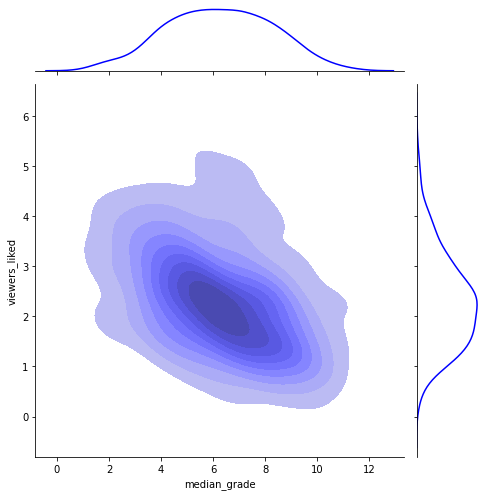

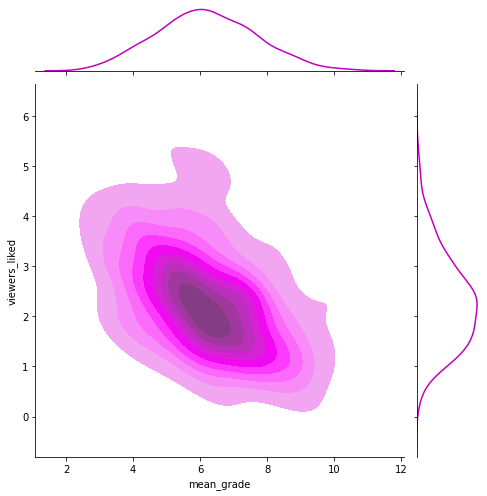

In [15]:
sns.jointplot(x = dataset['median_grade'], y = dataset['viewers_liked'], height = 7, color = 'b', 
              shade = True, kind = 'kde')
sns.jointplot(x = dataset['mean_grade'], y = dataset['viewers_liked'], height = 7, color = 'm', 
              shade = True, kind = 'kde')

Seems like stories with higher grades tend to be liked less by viewers. This may happen because low and high grades causes  too low or too high viewers's expectations respectivly. Then, if story quality doesn't met viewers expectations, they may prefer to like storyes with lower rating and do not like higher rated.

To examine the relationship between jury rating and viewer's likes we may check distributions of audience like ratio for each grade in jury median grades.

In [16]:
pd.unique(dataset['median_grade'])

array([ 4. ,  7. , 10. ,  5. ,  5.5,  8. ,  6. ,  4.5, 11. ,  2. ,  6.5,
        7.5,  3.5,  8.5,  9. ,  3. ,  9.5,  1.5])

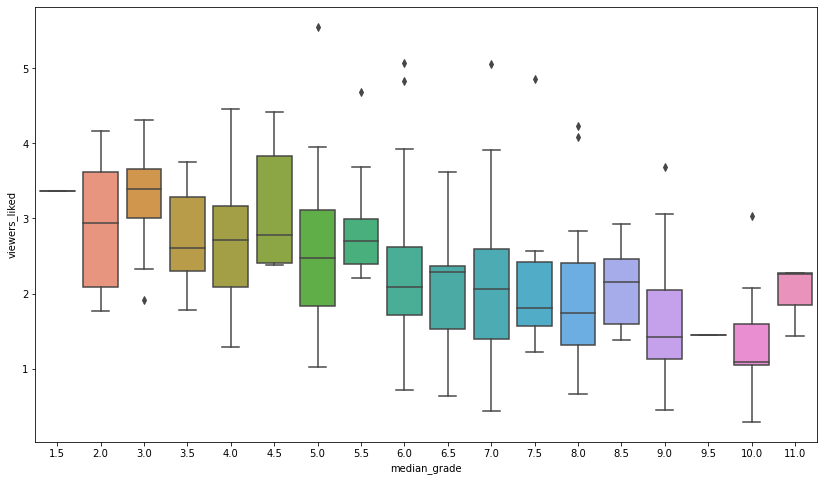

In [17]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = dataset['median_grade'],
           y = dataset['viewers_liked'])

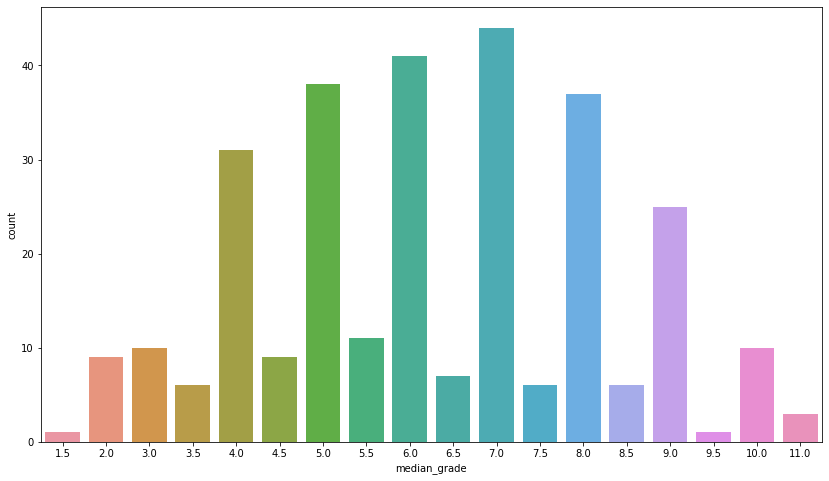

In [17]:
plt.figure(figsize = (14, 8))
sns.countplot(x = dataset['median_grade'])

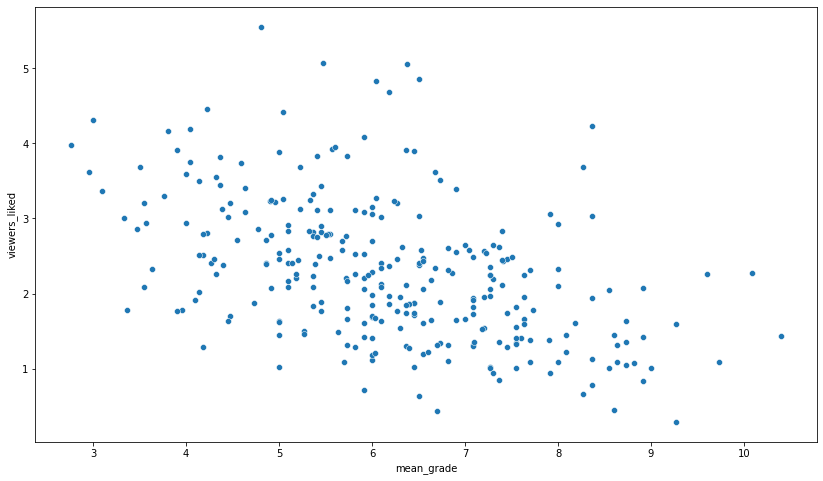

In [16]:
plt.figure(figsize = (14, 8))
sns.scatterplot(x = dataset['mean_grade'], y = dataset['viewers_liked'])

As we can see, most stories with higher jury rating has lower viewer's like ratio.

#### Check the disributions in jury and viewer's rating.

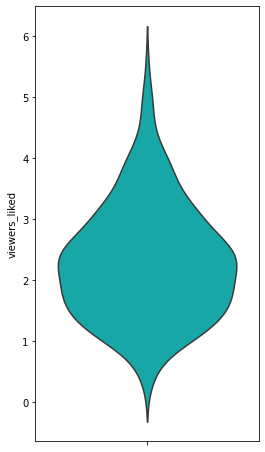

In [18]:
plt.figure(figsize = (4, 8))
sns.violinplot(y = dataset['viewers_liked'], inner = None, color = 'c')

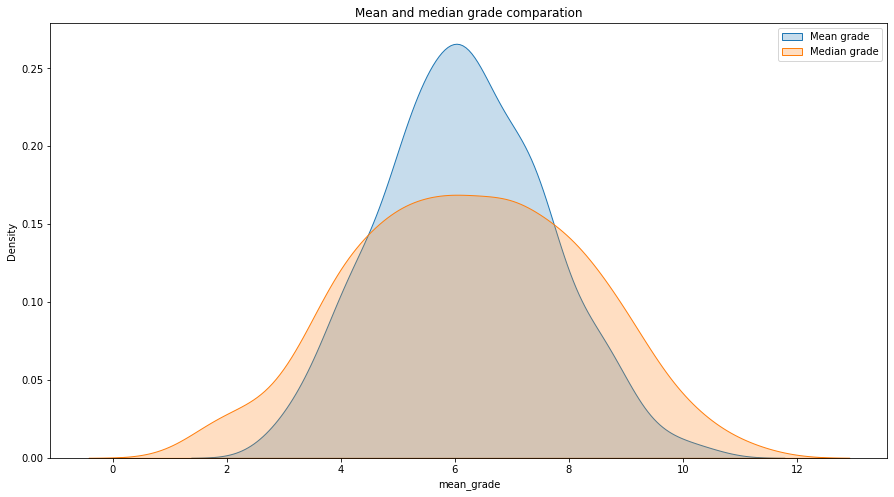

In [20]:
plt.figure(figsize = (15, 8))
sns.kdeplot(data = dataset['mean_grade'], label = 'Mean grade', shade = True)
sns.kdeplot(data = dataset['median_grade'], label = 'Median grade', shade = True)
plt.title('Mean and median grade comparation')
plt.legend()

Viewer's like rating is mostly low, but jury rating distribution is close to normal.
### Adding some functions for text frequency analysys.
#### First we define functions for:
* splitting text paragraph to sentences
* splitting a sentence to words

#### Then calculate average word, sentence and paragraph length for each text and examine if any of these charachteristics correlate with text grades.

In [21]:
#Splitting a paragraph to sentences.
def cut2sent(text):
    sentences = re.findall(r'[^.]+[.!?]', text)
    if sentences:
        return sentences
    else:
        return [text]

#Splitting a sentence to words
def cut2words(sent):
    words = re.split(r'[,;:-]\W|\W', sent)
    return [word for word in words if word]

#Find mean and median word length for given text
def word_mean_median(text, metric = 'mean'):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    lengths = []
    for sent in sentences:
        lengths.extend([len(word) for word in cut2words(sent)])
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

#Find mean and median sentence lendth (measured in number of words) for given text
def sentence_mean_median(text, metric = 'mean'):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    lengths = []
    for sent in sentences:
        lengths.append(len(cut2words(sent)))
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

#Mean or median paragraph length (measured in number of words)
def paragraph_mean_median(pars, metric = 'mean'):
    lengths = []
    for par in pars:
        length_words = 0
        for sentence in cut2sent(par):
            length_words += len(cut2words(sentence))
        lengths.append(length_words)
    if metric == 'median':
        return np.median(lengths)
    else:
        return np.mean(lengths)

In [22]:
freq_set = dataset[['mean_grade', 'median_grade', 'viewers_liked', 'text']].copy()
freq_set['mean_word_length'] = freq_set['text'].apply(word_mean_median)
freq_set['median_word_length'] = freq_set['text'].apply(lambda x: word_mean_median(x, 'median'))
freq_set['mean_sentence_length'] = freq_set['text'].apply(sentence_mean_median)
freq_set['median_sentence_length'] = freq_set['text'].apply(lambda x: sentence_mean_median(x, 'median'))
freq_set['mean_paragraph_length'] = freq_set['text'].apply(paragraph_mean_median)
freq_set['median_paragraph_length'] = freq_set['text'].apply(lambda x: paragraph_mean_median(x, 'median'))

In [23]:
freq_set.head

<bound method NDFrame.head of      mean_grade  median_grade  viewers_liked  \
0      5.363636           4.0       2.824859   
1      6.863636           7.0       2.272727   
2      9.272727          10.0       0.285442   
3      5.454545           5.0       1.881188   
4      5.200000           5.5       2.442529   
..          ...           ...            ...   
290    5.909091           5.5       3.084833   
291    5.476190           6.0       5.079365   
292    5.909091           5.0       2.526316   
293    5.428571           6.0       2.496100   
294    4.318182           3.5       2.255639   

                                                  text  mean_word_length  \
0    [На часах 14:15, - Сеть пропала, - цокнула язы...          5.576987   
1    [Парящая: Небесный патруль, Мне всегда было ин...          5.442478   
2    [Код Манны, «Неудачница», «Бездарная», «Уродин...          4.968131   
3    [Спасение, Фантастический рассказ "Спасение", ...          5.050151   
4    [Маг по 

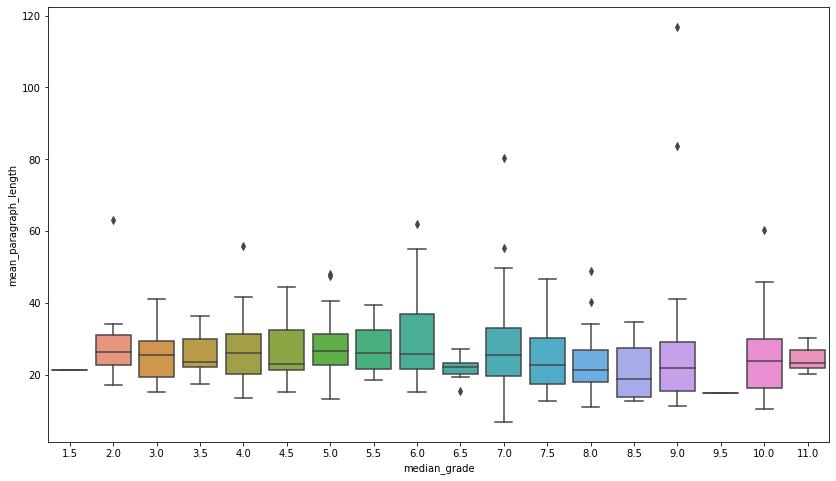

In [26]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = freq_set['median_grade'], y = freq_set['mean_paragraph_length'])

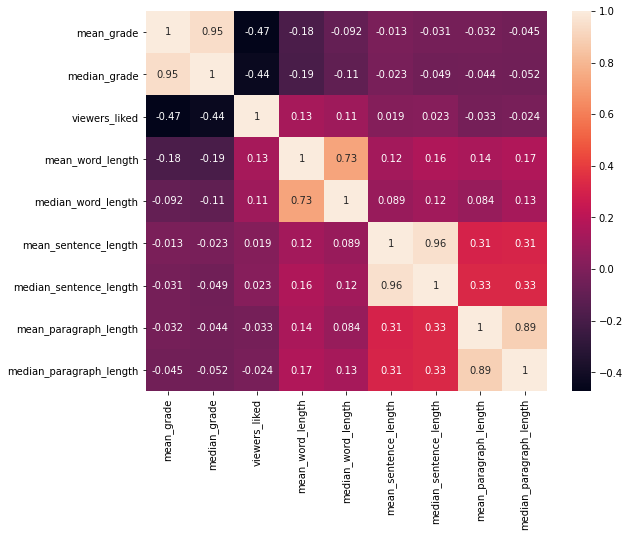

In [27]:
plt.figure(figsize = (9, 7))
sns.heatmap(freq_set.corr(), annot = True)

#### There is no significant correlation between grades and text frequency charachteristics.

In [28]:
morph = MorphAnalyzer()

#Basic function for extraction pymorphy2 OpencorporaTag for given word
def word_data(word):
    all_data = morph.parse(word)
    selected_tag = sorted(all_data, key = lambda data: data.score, reverse = True)[0]
    return selected_tag

#Function for ranking word according to its semantic value
def word_rank(word):
    word_rank = 6
    ranks = [{'rank': 1, 'forms': {'NOUN': 'nomn', 'NPRO': 'nomn', 'VERB': '', 'INFN': ''}},
            {'rank': 2, 'forms': {'NOUN': '', 'NPRO': '', 'PRTF': '', 'PRTS': '', 'GRND': ''}},
            {'rank': 3, 'forms': {'ADJF': '', 'ADJS': '', 'ADVB': '', 'PRED': ''}},
            {'rank': 4, 'forms': {'COMP': '', 'NUMR': ''}},
            {'rank': 5, 'forms': {'PREP': '', 'CONJ': '', 'PRCL': ''}},
            {'rank': 6, 'forms': {'INTJ': ''}}]
    description = word_data(word)
    for rank in ranks:
        for key in rank['forms']:
            if key in description.tag and rank['forms'][key] and rank['forms'][key] in description.tag:
                word_rank = rank['rank']
                break
            elif key in description.tag and not rank['forms'][key]:
                word_rank = rank['rank']
                break
    return word_rank

#Function for calculating stop-words ratio in given words
def non_semantic_ratio(words):
    non_semantic = 0
    for word in words:
        if word_rank(word) >= 4:
            non_semantic += 1 
    return non_semantic / len(words)

#Function for calculating ipm for every POS in given words
def count_POS(words):
    keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
    POS_count = dict.fromkeys(keys, 0)
    for word in words:
        oc_tag = word_data(word)
        key = oc_tag.tag.POS
        if key in keys:
            POS_count[key] += 1
    total = len(words)
    for key in POS_count:
        POS_count[key] = round((POS_count[key] / total) * 1000000, 3)
    return list(POS_count.values())

#Function for turning text to list of words
def text2words(text):
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    words = []
    for sentence in sentences:
        words.extend(cut2words(sentence))
    return words

In [29]:
#linguo_data = dataset[['mean_grade', 'median_grade', 'viewers_liked', 'text']].copy()
#linguo_data['stop_words_ratio'] = linguo_data['text'].apply(lambda x: non_semantic_ratio(text2words(x)))
#linguo_data['POS_vector'] = linguo_data['text'].apply(lambda x: count_POS(text2words(x)))

In [30]:
linguo_data = pd.read_json('linguo_data.json')

In [31]:
linguo_data.iloc[3]

mean_grade                                                    5.45455
median_grade                                                        5
viewers_liked                                                 1.88119
text                [Спасение, Фантастический рассказ "Спасение", ...
stop_words_ratio                                             0.264048
POS_vector          [96072.508, 10574.018, 71299.094, 5135.952, 10...
Name: 3, dtype: object

In [32]:
def cosine_similarity(a, b):
    return np.dot(a, b)/np.sqrt(a.dot(a)*b.dot(b))
linguo_data['np_vector'] = linguo_data['POS_vector'].apply(lambda x: np.array(x))
mean_vector = np.mean(linguo_data['np_vector'])

In [33]:
linguo_data['np_vector'][3]

array([ 96072.508,  10574.018,  71299.094,   5135.952, 103927.492,
         7552.87 ,  34138.973,   3927.492, 222658.61 , 123564.955,
         3021.148,  55891.239,   9063.444,  90634.441,   5438.066,
         1812.689, 153776.435])

In [34]:
linguo_data['cosine_similarity'] = linguo_data['np_vector'].apply(lambda x: cosine_similarity(mean_vector, x))

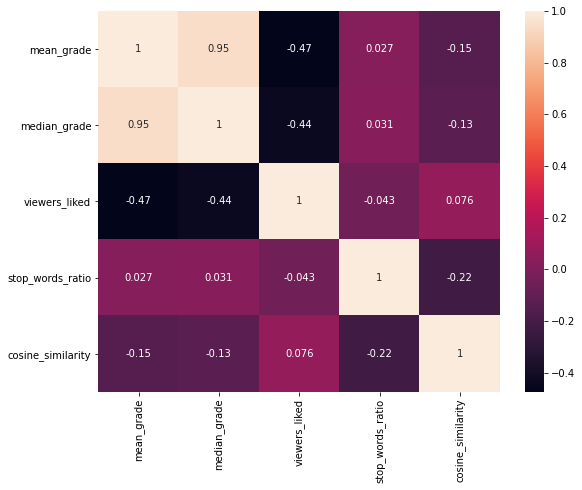

In [35]:
plt.figure(figsize = (9, 7))
sns.heatmap(linguo_data.corr(), annot = True)

In [41]:
#linguo_data.drop(columns = ['subtracted_vector', 'subtracted_cs'], inplace = True)
linguo_data.head()

,mean_grade,median_grade,viewers_liked,text,stop_words_ratio,POS_vector,np_vector,cosine_similarity
0,5.363636,4.0,2.824859,"[На часах 14:15, - Сеть пропала, - цокнула язы...",0.228182,"[98110.061, 10839.355, 45858.81, 2223.457, 675...","[98110.061, 10839.355, 45858.81, 2223.457, 675...",0.988661
1,6.863636,7.0,2.272727,"[Парящая: Небесный патруль, Мне всегда было ин...",0.254068,"[116471.596, 7422.21, 63659.72, 3996.574, 8621...","[116471.596, 7422.21, 63659.72, 3996.574, 8621...",0.996621
2,9.272727,10.0,0.285442,"[Код Манны, «Неудачница», «Бездарная», «Уродин...",0.276145,"[102568.069, 9591.584, 54146.04, 5414.604, 108...","[102568.069, 9591.584, 54146.04, 5414.604, 108...",0.985222
3,5.454545,5.0,1.881188,"[Спасение, Фантастический рассказ ""Спасение"", ...",0.264048,"[96072.508, 10574.018, 71299.094, 5135.952, 10...","[96072.508, 10574.018, 71299.094, 5135.952, 10...",0.973358
4,5.200000,5.5,2.442529,"[Маг по особым поручениям, – Ваши документы, м...",0.243482,"[126997.477, 5466.779, 57611.438, 5046.257, 92...","[126997.477, 5466.779, 57611.438, 5046.257, 92...",0.992491


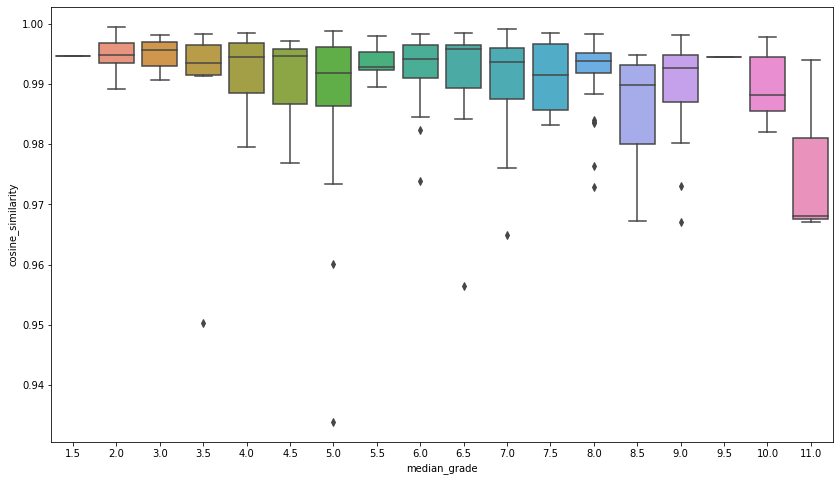

In [47]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = linguo_data['median_grade'], y = linguo_data['cosine_similarity'])

In [71]:
#Function for calculating mean POS vector for sentences of given text
def sentence_vectors(text):
    keys = ['ADJF', 'ADJS', 'ADVB', 'COMP', 'CONJ', 'GRND', 'INFN', 'INTJ', 'NOUN', 'NPRO', 
            'NUMR', 'PRCL', 'PRED', 'PREP', 'PRTF', 'PRTS', 'VERB']
    vectors = []
    if isinstance(text, list):
        sentences = cut2sent(' '.join(text))
    else:
        sentences = cut2sent(text)
    for sentence in sentences:
        POS_presence = dict.fromkeys(keys, 0)
        for word in cut2words(sentence):
            oc_tag = word_data(word)
            key = oc_tag.tag.POS
            if key in keys:
                POS_presence[key] = 1
        values = list(POS_presence.values())
        vectors.append(np.array(values))
    return vectors    

In [84]:
linguo_data['mean_sentence_vector'] = 0

In [91]:
linguo_data['mean_sentence_vector'] = linguo_data['text'].apply(lambda x: np.mean(sentence_vectors(x), axis = 0))

In [92]:
mean_v = np.mean(linguo_data['mean_sentence_vector'], axis = 0)
mean_v

array([0.60740869, 0.09654741, 0.4903931 , 0.0513701 , 0.59147031,
       0.15861961, 0.24923872, 0.02236441, 0.90204999, 0.50369825,
       0.05232393, 0.36315387, 0.04500802, 0.65102308, 0.13070122,
       0.02644038, 0.87246077])

In [93]:
linguo_data['sentence_cos_sim'] = linguo_data['mean_sentence_vector'].apply(lambda x: cosine_similarity(x, mean_v))

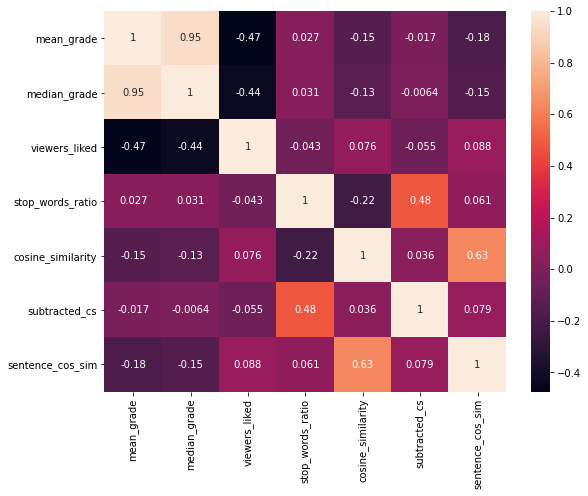

In [94]:
plt.figure(figsize = (9, 7))
sns.heatmap(linguo_data.corr(), annot = True)

In [98]:
linguo_data.to_json('sentence_vectors.json')